In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron
from scipy.sparse.linalg import expm
large = 40; med = 20; small = 10
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update(params)

# Energy cost function

## Unitary ansatz with depolarizing noise

Initial angles: [[-0.8635242144188006, -0.7229452784167156], [-0.22943436016191399, 0.6589830413639417]]

--- Starting VQE (Gradient Ascent for Maximization) ---
Using unitary ansatz (2 params/layer)
Iter 000: Cost = +0.561303
Iter 001: Cost = +0.670849
Iter 002: Cost = +0.750206
Iter 003: Cost = +0.785835
Iter 004: Cost = +0.797612
Iter 005: Cost = +0.798103
Iter 006: Cost = +0.793433
Iter 007: Cost = +0.786758
Iter 008: Cost = +0.779920
Iter 009: Cost = +0.774294
Iter 010: Cost = +0.770240
Iter 011: Cost = +0.767830
Iter 012: Cost = +0.767065
Iter 013: Cost = +0.767962
Iter 014: Cost = +0.770548


/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


Iter 015: Cost = +0.774814
Iter 016: Cost = +0.780627
Iter 017: Cost = +0.787496
Iter 018: Cost = +0.794583
Iter 019: Cost = +0.800964
Iter 020: Cost = +0.805693
Iter 021: Cost = +0.807931
Iter 022: Cost = +0.807035
Iter 023: Cost = +0.802592
Iter 024: Cost = +0.794426
Iter 025: Cost = +0.782569
Iter 026: Cost = +0.767228
Iter 027: Cost = +0.748760
Iter 028: Cost = +0.727648
Iter 029: Cost = +0.704475
Iter 030: Cost = +0.679900
Iter 031: Cost = +0.654616
Iter 032: Cost = +0.629301
Iter 033: Cost = +0.604552
Iter 034: Cost = +0.580829
Iter 035: Cost = +0.558413
Iter 036: Cost = +0.537389
Iter 037: Cost = +0.517676
Iter 038: Cost = +0.499066
Iter 039: Cost = +0.481279
Iter 040: Cost = +0.464003
Iter 041: Cost = +0.446919
Iter 042: Cost = +0.429708
Iter 043: Cost = +0.412044
Iter 044: Cost = +0.393582
Iter 045: Cost = +0.373930
Iter 046: Cost = +0.352619
Iter 047: Cost = +0.329059
Iter 048: Cost = +0.302479
Iter 033: Cost = +0.604552
Iter 034: Cost = +0.580829
Iter 035: Cost = +0.558413
I

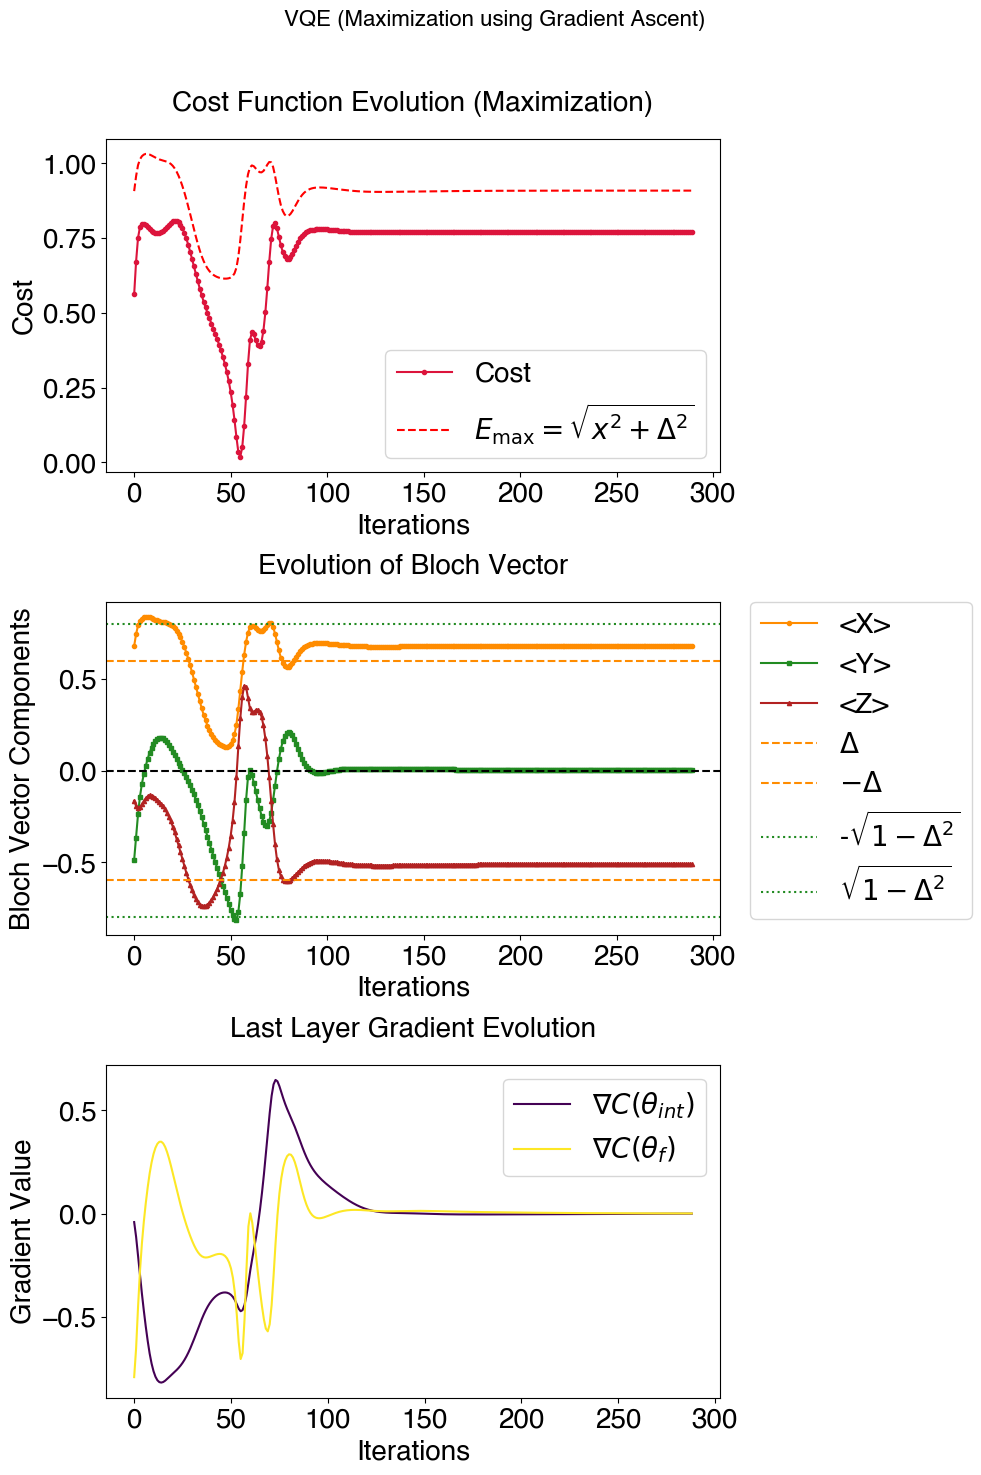

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron, eye, identity
from scipy.sparse.linalg import expm

class UnitaryVQE:
    """
    Finds the maximum energy state of a self-consistent mean-field Hamiltonian
    H(x) = x*X - Delta*Z using gradient ascent. The ansatz can include
    non-unitary dissipative gates and depolarizing noise, and correctly
    reduces to the simpler model when dissipative rates are zero.
    """

    # --- Pauli Matrices (Class Attributes) ---
    I2 = csc_matrix(np.eye(2, dtype=complex))
    X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
    Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
    Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

    def __init__(self, Delta=0.5, gamma_r=0.0, gamma_d=0.0, gamma_depol=0.0):
        """
        Initializes the optimizer with system and noise parameters.
        """
        self.Delta = Delta
        self.gamma_r = gamma_r
        self.gamma_d = gamma_d
        self.gamma_depol = gamma_depol
        self.is_dissipative = gamma_r > 0 or gamma_d > 0
        self.n_params = 4 if self.is_dissipative else 2
        
        # Dissipative operators for non-unitary gates
        self.L1_op = np.sqrt(gamma_r) * csc_matrix((self.X - 1j * self.Y) / 2) if gamma_r > 0 else csc_matrix((0,0))
        self.L2_op = np.sqrt(gamma_d) * csc_matrix((self.I2.toarray() + self.Z.toarray()) / 2) if gamma_d > 0 else csc_matrix((0,0))

        # Depolarizing noise channel
        self.D_mat = self._get_depolarizing_superop()
        self.D_mat_sparse = csc_matrix(self.D_mat)

        # Storage for results
        self.cost_history = []
        self.gradients_history = []
        self.rho_history = []
        self.x_history = []
        self.y_history = []
        self.z_history = []
        self.best_angles = None
        self.best_cost = -np.inf

    @staticmethod
    def _vectorize(rho):
        if hasattr(rho, "toarray"):
            rho = rho.toarray()
        return csc_matrix(rho.flatten(order="F")[:, None])

    @staticmethod
    def _unvectorize(rho_vec):
        rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
        return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

    def _get_bloch_vector(self, rho_mat):
        x = np.real(np.trace((self.X @ rho_mat).toarray()))
        y = np.real(np.trace((self.Y @ rho_mat).toarray()))
        z = np.real(np.trace((self.Z @ rho_mat).toarray()))
        return x, y, z

    def _L_depol_super(self):
        term_x = kron(self.X.conj(), self.X, format='csc')
        term_y = kron(self.Y.conj(), self.Y, format='csc')
        term_z = kron(self.Z.conj(), self.Z, format='csc')
        term_I = kron(self.I2, self.I2, format='csc')
        return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

    def _get_depolarizing_superop(self):
        if abs(self.gamma_depol) < 1e-12:
            return identity(4, dtype=complex, format='csc')
        return expm(self._L_depol_super())

    def _L_int_ansatz(self, x_mean):
        H_int = x_mean * self.X
        return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))
    
    def _L_f_ansatz(self):
        H_f = -self.Delta * self.Z
        return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

    def _L_rel_ansatz(self):
        if self.gamma_r <= 0:
            return csc_matrix((4,4), dtype=complex)
        L_op = self.L1_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _L_dep_ansatz(self):
        if self.gamma_d <= 0:
            return csc_matrix((4,4), dtype=complex)
        L_op = self.L2_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _get_hamiltonian(self, x_val):
        return x_val * self.X - self.Delta * self.Z

    def _cost_function(self, rho_final_mat, x_final):
        H_final = self._get_hamiltonian(x_final)
        return np.real(np.trace((H_final @ rho_final_mat).toarray()))

    def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history, bloch_history):
        grads = [[0.0] * self.n_params for _ in range(n_layers)]
        rho_final_vec = rho_history[-1]
        rho_final_mat = self._unvectorize(rho_final_vec)
        x_final = x_history[-1]
        H_final = self._get_hamiltonian(x_final)

        for l in range(n_layers):
            propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
            for i in range(l + 1, n_layers):
                propagator_after_layer = propagators[i] @ propagator_after_layer
            
            rho_before_layer = rho_history[l]

            def compute_gradient_from_drho(d_rho_final_vec):
                d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
                term1 = x_final * dx_dtheta
                term2 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
                return term1 + term2
            
            D = self.D_mat_sparse

            if not self.is_dissipative:
                E_int, E_f = evolvers[0][l], evolvers[1][l]
                
                # Grad theta_int
                rho_pre_U = D @ rho_before_layer
                x_pre_U, y_pre_U, z_pre_U = self._get_bloch_vector(self._unvectorize(rho_pre_U))
                deriv_mat_local = x_pre_U * (y_pre_U * self.Z - z_pre_U * self.Y)
                deriv_vec_local = self._vectorize(deriv_mat_local)
                prop_from_int = D @ E_f
                d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
                grads[l][0] = compute_gradient_from_drho(d_rho_final)
                
                # Grad theta_f
                rho_post_f = E_f @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_f_ansatz() @ rho_post_f
                prop_from_f = D
                d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
                grads[l][1] = compute_gradient_from_drho(d_rho_final)
                
            else:
                E_int, E_f, E_rel, E_dep = evolvers[0][l], evolvers[1][l], evolvers[2][l], evolvers[3][l]

                rho_pre_int = D @ rho_before_layer
                x_pre_int, y_pre_int, z_pre_int = self._get_bloch_vector(self._unvectorize(rho_pre_int))
                deriv_mat_local = x_pre_int * (y_pre_int * self.Z - z_pre_int * self.Y)
                deriv_vec_local = self._vectorize(deriv_mat_local)
                prop_from_int = D @ E_dep @ D @ E_rel @ D @ E_f @ D
                d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
                grads[l][0] = compute_gradient_from_drho(d_rho_final)
                
                rho_post_f = E_f @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_f_ansatz() @ rho_post_f
                prop_from_f = D @ E_dep @ D @ E_rel @ D
                d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
                grads[l][1] = compute_gradient_from_drho(d_rho_final)

                rho_post_rel = E_rel @ D @ E_f @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_rel_ansatz() @ rho_post_rel
                prop_from_rel = D @ E_dep @ D
                d_rho_final = propagator_after_layer @ prop_from_rel @ deriv_vec_local
                grads[l][2] = compute_gradient_from_drho(d_rho_final)

                rho_post_dep = E_dep @ D @ E_rel @ D @ E_f @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_dep_ansatz() @ rho_post_dep
                prop_from_dep = D
                d_rho_final = propagator_after_layer @ prop_from_dep @ deriv_vec_local
                grads[l][3] = compute_gradient_from_drho(d_rho_final)

        return grads

    def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):
        rho_vec = rho_initial_vec.copy()
        rho_history = [rho_vec]
        x_history = []
        bloch_history = []
        evolvers = ([], [], [], []) if self.is_dissipative else ([], [])
        propagators = []
        D = self.D_mat_sparse

        for i in range(n_layers):
            if self.is_dissipative:
                theta_int, theta_f, theta_rel, theta_dep = angles_list[i]
            else:
                theta_int, theta_f = angles_list[i]
                theta_rel, theta_dep = 0.0, 0.0
            
            rho_current_mat = self._unvectorize(rho_vec)
            x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
            x_history.append(x_current)
            bloch_history.append((x_current, y_current, z_current))

            # This is the same x used in the simpler unitary program
            E_int = expm(theta_int * self._L_int_ansatz(x_current))
            E_f   = expm(theta_f   * self._L_f_ansatz())
            
            if self.is_dissipative:
                E_rel = expm(theta_rel * self._L_rel_ansatz())
                E_dep = expm(theta_dep * self._L_dep_ansatz())
                M = D @ E_dep @ D @ E_rel @ D @ E_f @ D @ E_int @ D
            else:
                U = E_f @ E_int
                M = D @ U @ D

            rho_vec = M @ rho_vec
            
            rho_mat_temp = self._unvectorize(rho_vec)
            trace_val = np.trace(rho_mat_temp.toarray())
            if abs(trace_val) > 1e-12:
                 rho_vec = self._vectorize(rho_mat_temp / trace_val)
            
            rho_history.append(rho_vec)
            evolvers[0].append(E_int)
            evolvers[1].append(E_f)
            if self.is_dissipative:
                evolvers[2].append(E_rel)
                evolvers[3].append(E_dep)
            propagators.append(M)

        x_final, _, _ = self._get_bloch_vector(self._unvectorize(rho_vec))
        x_history.append(x_final)

        return rho_vec, evolvers, propagators, rho_history, x_history, bloch_history

    def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
        # Ensure initial_angles has correct number of parameters
        expected_params = self.n_params
        for i, layer_angles in enumerate(initial_angles):
            if len(layer_angles) != expected_params:
                raise ValueError(f"Layer {i}: Expected {expected_params} parameters, got {len(layer_angles)}")
                
        rx = np.sqrt(1 - self.Delta**2)
        ry = 0.0
        rz = - self.Delta

        rho_initial_mat = (self.I2.toarray() + rx*self.X.toarray() + ry*self.Y.toarray() + rz*self.Z.toarray())/2
        rho_initial_mat /= np.trace(rho_initial_mat)
        rho_initial_vec = self._vectorize(rho_initial_mat)
        
        angles = [list(params) for params in initial_angles]
        self.best_angles = [list(a) for a in angles]
        self.best_cost = -np.inf

        print("\n--- Starting VQE (Gradient Ascent for Maximization) ---")
        print(f"Using {'dissipative' if self.is_dissipative else 'unitary'} ansatz ({self.n_params} params/layer)")
        
        self.cost_history.clear()
        self.gradients_history.clear()
        self.rho_history = []
        self.x_history.clear()
        self.y_history.clear()
        self.z_history.clear()

        for iteration in range(max_iterations):
            rho_final_vec, evolvers, propagators, rho_hist, x_hist, bloch_hist = \
                self._variational_ansatz(n_layers, angles, rho_initial_vec)

            rho_final_mat = self._unvectorize(rho_final_vec)
            self.rho_history.append(rho_final_mat)
            x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
            current_cost = self._cost_function(rho_final_mat, x_final)

            self.cost_history.append(current_cost)
            self.x_history.append(x_final)
            self.y_history.append(y_final)
            self.z_history.append(z_final)
            
            if current_cost > self.best_cost:
                self.best_cost = current_cost
                self.best_angles = [list(a) for a in angles]
            
            print(f"Iter {iteration:03d}: Cost = {current_cost:+.6f}")

            if iteration > 1 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
                print(f"\nConvergence criterion met at iteration {iteration}!")
                break
            
            gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist, bloch_hist)
            self.gradients_history.append(gradients)
            
            grad_norm = np.linalg.norm(np.array(gradients))
            if grad_norm > clip_threshold:
                gradients = (np.array(gradients) * (clip_threshold / grad_norm)).tolist()
            
            for l in range(n_layers):
                for k in range(self.n_params):
                    angles[l][k] += learning_rate * gradients[l][k]
                    
        print("\n--- Optimization Finished ---")
        return self.best_angles, self.best_cost, self.cost_history, self.rho_history

    def plot_results(self):
        if not self.cost_history:
            print("No history to plot. Please run the VQA first.")
            return

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
        fig.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)

        ax1.plot(self.cost_history, 'o-', color='crimson', markersize=3, label='Cost')
        e_max = np.sqrt(np.array(self.x_history)**2 + self.Delta**2)
        ax1.plot(e_max, color='red', linestyle='--', label=r'$E_{\mathrm{max}}=\sqrt{x^{2}+\Delta^{2}}$')
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Cost")
        ax1.legend()
        ax1.set_title("Cost Function Evolution (Maximization)")

        iterations = range(len(self.x_history))
        ax2.plot(iterations, self.x_history, 'o-', color='darkorange', markersize=3, label='<X>')
        ax2.plot(iterations, self.y_history, 's-', color='forestgreen', markersize=3, label='<Y>')
        ax2.plot(iterations, self.z_history, '^-', color='firebrick', markersize=3, label='<Z>')
        ax2.axhline(self.Delta, color='darkorange', linestyle='--', label=r'$\Delta$')
        ax2.axhline(-self.Delta, color='darkorange', linestyle='--', label=r'$-\Delta$')        
        ax2.axhline(-np.sqrt(1 - self.Delta**2), color='forestgreen', linestyle=':', label=r'-$\sqrt{1 - \Delta^{2}}$')
        ax2.axhline(np.sqrt(1 - self.Delta**2), color='forestgreen', linestyle=':', label=r'$\sqrt{1 - \Delta^{2}}$')
        ax2.axhline(0, color='black', linestyle='--')
        
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("Bloch Vector Components")
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax2.set_title("Evolution of Bloch Vector")

        if self.gradients_history:
            last_layer_grads_history = np.array([g[-1] for g in self.gradients_history])
            grads_by_param = last_layer_grads_history.T
            param_names = ['int', 'f', 'rel', 'dep'][:self.n_params]
            colors = plt.cm.viridis(np.linspace(0, 1, self.n_params))
            for i, grad_line in enumerate(grads_by_param):
                ax3.plot(range(len(grad_line)), grad_line, lw=1.5, color=colors[i], 
                         label=f'$\\nabla C(\\theta_{{{param_names[i]}}})$')
        
        ax3.set_xlabel("Iterations")
        ax3.set_ylabel("Gradient Value")
        ax3.legend(loc='upper right')
        ax3.set_title("Last Layer Gradient Evolution")
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

if __name__ == '__main__':
    vqe = UnitaryVQE(
        Delta=0.6, 
        gamma_r=0.0,  # Set to 0 for unitary behavior
        gamma_d=0.0,  # Set to 0 for unitary behavior
        gamma_depol=0.01
    )
    
    n_layers = 2
    np.random.seed(1729)
    
    # Dynamically determine number of parameters needed
    n_params = vqe.n_params
    initial_angles = [
        [np.random.uniform(-1.5, 1.5) for _ in range(n_params)] 
        for _ in range(n_layers)
    ]
    print(f"Initial angles: {initial_angles}")

    best_angles, best_cost, cost_history, rho_history = vqe.run_vqa(
        n_layers=n_layers,
        initial_angles=initial_angles,
        learning_rate=0.1,
        max_iterations=300,
        tolerance=1e-7,
        clip_threshold=1.0
    )

    vqe.plot_results()

## Non-unitary ansatz with depolarizing noise

Initial angles: [[-0.8635242144188006, -0.7229452784167156], [-0.22943436016191399, 0.6589830413639417]]

--- Starting VQE (Gradient Ascent for Maximization) ---
Using unitary ansatz (2 params/layer)
Iter 000: Cost = +0.180357
Iter 001: Cost = +0.193355
Iter 002: Cost = +0.204711
Iter 003: Cost = +0.214400
Iter 004: Cost = +0.222491
Iter 005: Cost = +0.229111
Iter 006: Cost = +0.234422
Iter 007: Cost = +0.238599
Iter 008: Cost = +0.241810
Iter 009: Cost = +0.244212
Iter 010: Cost = +0.245942
Iter 011: Cost = +0.247119
Iter 012: Cost = +0.247842
Iter 013: Cost = +0.248195
Iter 014: Cost = +0.248246
Iter 015: Cost = +0.248051
Iter 016: Cost = +0.247657
Iter 017: Cost = +0.247099
Iter 018: Cost = +0.246409
Iter 019: Cost = +0.245611
Iter 020: Cost = +0.244725
Iter 021: Cost = +0.243766
Iter 022: Cost = +0.242746
Iter 023: Cost = +0.241677
Iter 024: Cost = +0.240565
Iter 025: Cost = +0.239415
Iter 026: Cost = +0.238233
Iter 027: Cost = +0.237019
Iter 028: Cost = +0.235775
Iter 029: Cost = 

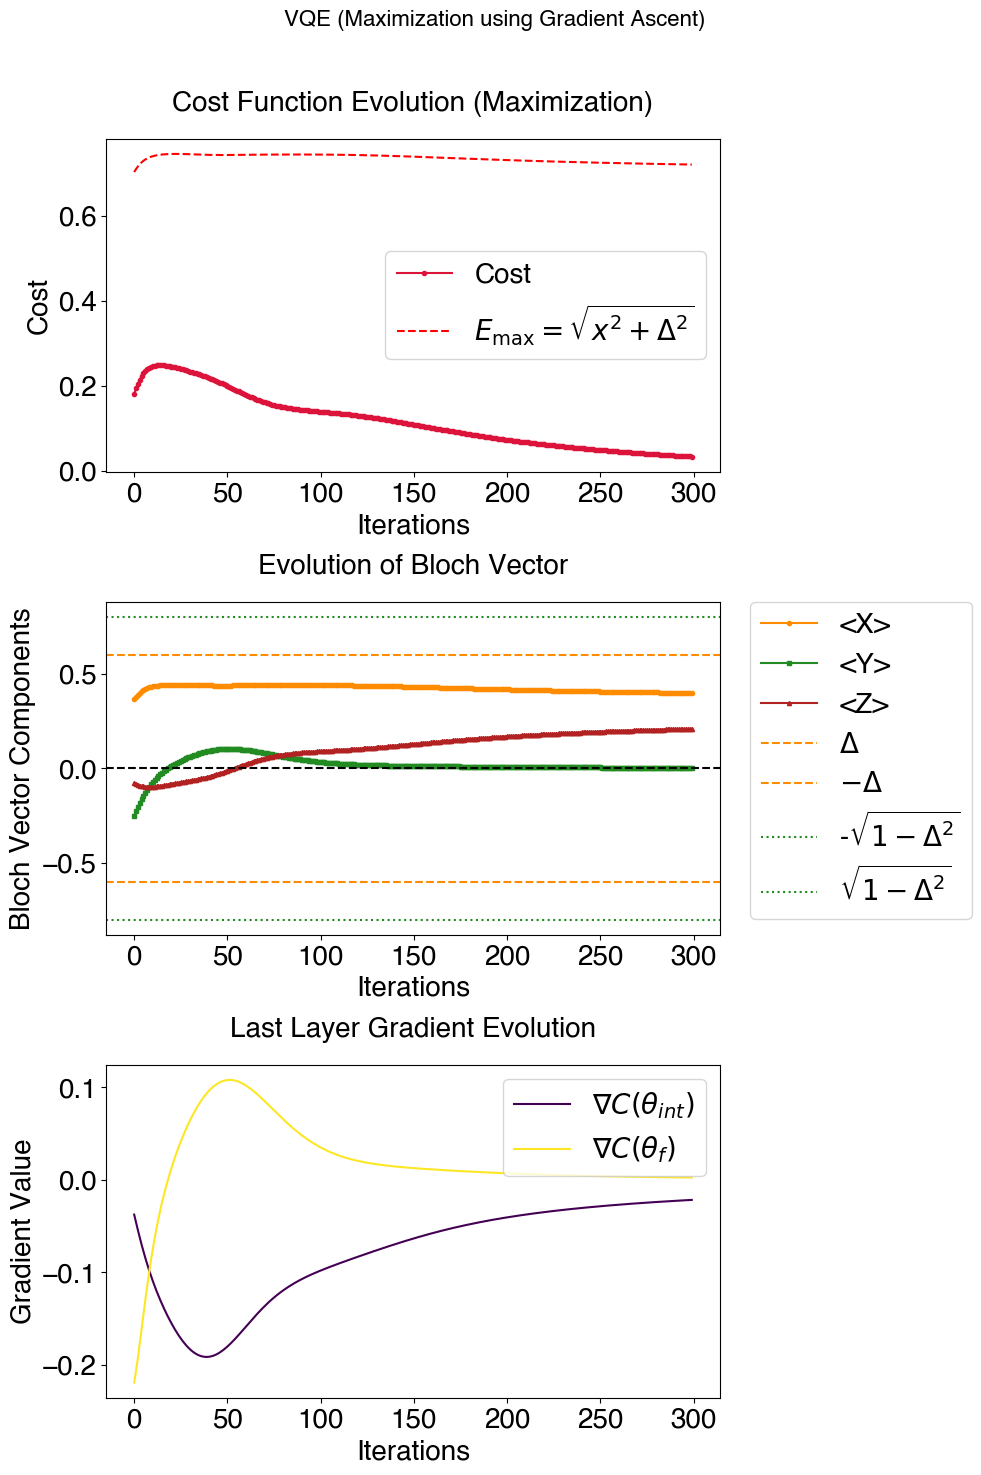

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron, eye, identity
from scipy.sparse.linalg import expm

class NonUnitaryVQE:
    """
    Finds the maximum energy state of a self-consistent mean-field Hamiltonian
    H(x) = x*X - Delta*Z using gradient ascent. The ansatz can include
    non-unitary dissipative gates and depolarizing noise, and correctly
    reduces to the simpler model when dissipative rates are zero.
    """

    # --- Pauli Matrices (Class Attributes) ---
    I2 = csc_matrix(np.eye(2, dtype=complex))
    X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
    Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
    Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

    def __init__(self, Delta=0.5, gamma_r=0.0, gamma_d=0.0, gamma_depol=0.0):
        """
        Initializes the optimizer with system and noise parameters.
        """
        self.Delta = Delta
        self.gamma_r = gamma_r
        self.gamma_d = gamma_d
        self.gamma_depol = gamma_depol
        self.is_dissipative = gamma_r > 0 or gamma_d > 0
        self.n_params = 4 if self.is_dissipative else 2
        
        # Dissipative operators for non-unitary gates
        self.L1_op = np.sqrt(gamma_r) * csc_matrix((self.X - 1j * self.Y) / 2) if gamma_r > 0 else csc_matrix((0,0))
        self.L2_op = np.sqrt(gamma_d) * csc_matrix((self.I2.toarray() + self.Z.toarray()) / 2) if gamma_d > 0 else csc_matrix((0,0))

        # Depolarizing noise channel
        self.D_mat = self._get_depolarizing_superop()
        self.D_mat_sparse = csc_matrix(self.D_mat)

        # Storage for results
        self.cost_history = []
        self.gradients_history = []
        self.rho_history = []
        self.x_history = []
        self.y_history = []
        self.z_history = []
        self.best_angles = None
        self.best_cost = -np.inf

    @staticmethod
    def _vectorize(rho):
        if hasattr(rho, "toarray"):
            rho = rho.toarray()
        return csc_matrix(rho.flatten(order="F")[:, None])

    @staticmethod
    def _unvectorize(rho_vec):
        rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
        return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

    def _get_bloch_vector(self, rho_mat):
        x = np.real(np.trace((self.X @ rho_mat).toarray()))
        y = np.real(np.trace((self.Y @ rho_mat).toarray()))
        z = np.real(np.trace((self.Z @ rho_mat).toarray()))
        return x, y, z

    def _L_depol_super(self):
        term_x = kron(self.X.conj(), self.X, format='csc')
        term_y = kron(self.Y.conj(), self.Y, format='csc')
        term_z = kron(self.Z.conj(), self.Z, format='csc')
        term_I = kron(self.I2, self.I2, format='csc')
        return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

    def _get_depolarizing_superop(self):
        if abs(self.gamma_depol) < 1e-12:
            return identity(4, dtype=complex, format='csc')
        return expm(self._L_depol_super())

    def _L_int_ansatz(self, x_mean):
        H_int = x_mean * self.X
        return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))
    
    def _L_f_ansatz(self):
        H_f = -self.Delta * self.Z
        return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

    def _L_rel_ansatz(self):
        if self.gamma_r <= 0:
            return csc_matrix((4,4), dtype=complex)
        L_op = self.L1_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _L_dep_ansatz(self):
        if self.gamma_d <= 0:
            return csc_matrix((4,4), dtype=complex)
        L_op = self.L2_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _get_hamiltonian(self, x_val):
        return x_val * self.X - self.Delta * self.Z

    def _cost_function(self, rho_final_mat, x_final):
        H_final = self._get_hamiltonian(x_final)
        return np.real(np.trace((H_final @ rho_final_mat).toarray()))

    def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history, bloch_history):
        grads = [[0.0] * self.n_params for _ in range(n_layers)]
        rho_final_vec = rho_history[-1]
        rho_final_mat = self._unvectorize(rho_final_vec)
        x_final = x_history[-1]
        H_final = self._get_hamiltonian(x_final)

        for l in range(n_layers):
            propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
            for i in range(l + 1, n_layers):
                propagator_after_layer = propagators[i] @ propagator_after_layer
            
            rho_before_layer = rho_history[l]

            def compute_gradient_from_drho(d_rho_final_vec):
                d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
                term1 = x_final * dx_dtheta
                term2 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
                return term1 + term2
            
            D = self.D_mat_sparse

            if not self.is_dissipative:
                E_int, E_f = evolvers[0][l], evolvers[1][l]
                
                # Grad theta_int
                rho_pre_U = D @ rho_before_layer
                x_pre_U, y_pre_U, z_pre_U = self._get_bloch_vector(self._unvectorize(rho_pre_U))
                deriv_mat_local = x_pre_U * (y_pre_U * self.Z - z_pre_U * self.Y)
                deriv_vec_local = self._vectorize(deriv_mat_local)
                prop_from_int = D @ E_f
                d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
                grads[l][0] = compute_gradient_from_drho(d_rho_final)
                
                # Grad theta_f
                rho_post_f = E_f @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_f_ansatz() @ rho_post_f
                prop_from_f = D
                d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
                grads[l][1] = compute_gradient_from_drho(d_rho_final)
                
            else:
                E_int, E_f, E_rel, E_dep = evolvers[0][l], evolvers[1][l], evolvers[2][l], evolvers[3][l]

                rho_pre_int = D @ rho_before_layer
                x_pre_int, y_pre_int, z_pre_int = self._get_bloch_vector(self._unvectorize(rho_pre_int))
                deriv_mat_local = x_pre_int * (y_pre_int * self.Z - z_pre_int * self.Y)
                deriv_vec_local = self._vectorize(deriv_mat_local)
                prop_from_int = D @ E_dep @ D @ E_rel @ D @ E_f @ D
                d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
                grads[l][0] = compute_gradient_from_drho(d_rho_final)
                
                rho_post_f = E_f @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_f_ansatz() @ rho_post_f
                prop_from_f = D @ E_dep @ D @ E_rel @ D
                d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
                grads[l][1] = compute_gradient_from_drho(d_rho_final)

                rho_post_rel = E_rel @ D @ E_f @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_rel_ansatz() @ rho_post_rel
                prop_from_rel = D @ E_dep @ D
                d_rho_final = propagator_after_layer @ prop_from_rel @ deriv_vec_local
                grads[l][2] = compute_gradient_from_drho(d_rho_final)

                rho_post_dep = E_dep @ D @ E_rel @ D @ E_f @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_dep_ansatz() @ rho_post_dep
                prop_from_dep = D
                d_rho_final = propagator_after_layer @ prop_from_dep @ deriv_vec_local
                grads[l][3] = compute_gradient_from_drho(d_rho_final)

        return grads

    def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):
        rho_vec = rho_initial_vec.copy()
        rho_history = [rho_vec]
        x_history = []
        bloch_history = []
        evolvers = ([], [], [], []) if self.is_dissipative else ([], [])
        propagators = []
        D = self.D_mat_sparse

        for i in range(n_layers):
            if self.is_dissipative:
                theta_int, theta_f, theta_rel, theta_dep = angles_list[i]
            else:
                theta_int, theta_f = angles_list[i]
                theta_rel, theta_dep = 0.0, 0.0
            
            rho_current_mat = self._unvectorize(rho_vec)
            x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
            x_history.append(x_current)
            bloch_history.append((x_current, y_current, z_current))

            # This is the same x used in the simpler unitary program
            E_int = expm(theta_int * self._L_int_ansatz(x_current))
            E_f   = expm(theta_f   * self._L_f_ansatz())
            
            if self.is_dissipative:
                E_rel = expm(theta_rel * self._L_rel_ansatz())
                E_dep = expm(theta_dep * self._L_dep_ansatz())
                M = D @ E_dep @ D @ E_rel @ D @ E_f @ D @ E_int @ D
            else:
                U = E_f @ E_int
                M = D @ U @ D

            rho_vec = M @ rho_vec
            
            rho_mat_temp = self._unvectorize(rho_vec)
            trace_val = np.trace(rho_mat_temp.toarray())
            if abs(trace_val) > 1e-12:
                 rho_vec = self._vectorize(rho_mat_temp / trace_val)
            
            rho_history.append(rho_vec)
            evolvers[0].append(E_int)
            evolvers[1].append(E_f)
            if self.is_dissipative:
                evolvers[2].append(E_rel)
                evolvers[3].append(E_dep)
            propagators.append(M)

        x_final, _, _ = self._get_bloch_vector(self._unvectorize(rho_vec))
        x_history.append(x_final)

        return rho_vec, evolvers, propagators, rho_history, x_history, bloch_history

    def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
        # Ensure initial_angles has correct number of parameters
        expected_params = self.n_params
        for i, layer_angles in enumerate(initial_angles):
            if len(layer_angles) != expected_params:
                raise ValueError(f"Layer {i}: Expected {expected_params} parameters, got {len(layer_angles)}")
                
        rx = np.sqrt(1 - self.Delta**2)
        ry = 0.0
        rz = - self.Delta

        rho_initial_mat = (self.I2.toarray() + rx*self.X.toarray() + ry*self.Y.toarray() + rz*self.Z.toarray())/2
        rho_initial_mat /= np.trace(rho_initial_mat)
        rho_initial_vec = self._vectorize(rho_initial_mat)
        
        angles = [list(params) for params in initial_angles]
        self.best_angles = [list(a) for a in angles]
        self.best_cost = -np.inf

        print("\n--- Starting VQE (Gradient Ascent for Maximization) ---")
        print(f"Using {'dissipative' if self.is_dissipative else 'unitary'} ansatz ({self.n_params} params/layer)")
        
        self.cost_history.clear()
        self.gradients_history.clear()
        self.rho_history = []
        self.x_history.clear()
        self.y_history.clear()
        self.z_history.clear()

        for iteration in range(max_iterations):
            rho_final_vec, evolvers, propagators, rho_hist, x_hist, bloch_hist = \
                self._variational_ansatz(n_layers, angles, rho_initial_vec)

            rho_final_mat = self._unvectorize(rho_final_vec)
            self.rho_history.append(rho_final_mat)
            x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
            current_cost = self._cost_function(rho_final_mat, x_final)

            self.cost_history.append(current_cost)
            self.x_history.append(x_final)
            self.y_history.append(y_final)
            self.z_history.append(z_final)
            
            if current_cost > self.best_cost:
                self.best_cost = current_cost
                self.best_angles = [list(a) for a in angles]
            
            print(f"Iter {iteration:03d}: Cost = {current_cost:+.6f}")

            if iteration > 1 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
                print(f"\nConvergence criterion met at iteration {iteration}!")
                break
            
            gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist, bloch_hist)
            self.gradients_history.append(gradients)
            
            grad_norm = np.linalg.norm(np.array(gradients))
            if grad_norm > clip_threshold:
                gradients = (np.array(gradients) * (clip_threshold / grad_norm)).tolist()
            
            for l in range(n_layers):
                for k in range(self.n_params):
                    angles[l][k] += learning_rate * gradients[l][k]
                    
        print("\n--- Optimization Finished ---")
        return self.best_angles, self.best_cost, self.cost_history, self.rho_history

    def plot_results(self):
        if not self.cost_history:
            print("No history to plot. Please run the VQA first.")
            return

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
        fig.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)

        ax1.plot(self.cost_history, 'o-', color='crimson', markersize=3, label='Cost')
        e_max = np.sqrt(np.array(self.x_history)**2 + self.Delta**2)
        ax1.plot(e_max, color='red', linestyle='--', label=r'$E_{\mathrm{max}}=\sqrt{x^{2}+\Delta^{2}}$')
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Cost")
        ax1.legend()
        ax1.set_title("Cost Function Evolution (Maximization)")

        iterations = range(len(self.x_history))
        ax2.plot(iterations, self.x_history, 'o-', color='darkorange', markersize=3, label='<X>')
        ax2.plot(iterations, self.y_history, 's-', color='forestgreen', markersize=3, label='<Y>')
        ax2.plot(iterations, self.z_history, '^-', color='firebrick', markersize=3, label='<Z>')
        ax2.axhline(self.Delta, color='darkorange', linestyle='--', label=r'$\Delta$')
        ax2.axhline(-self.Delta, color='darkorange', linestyle='--', label=r'$-\Delta$')        
        ax2.axhline(-np.sqrt(1 - self.Delta**2), color='forestgreen', linestyle=':', label=r'-$\sqrt{1 - \Delta^{2}}$')
        ax2.axhline(np.sqrt(1 - self.Delta**2), color='forestgreen', linestyle=':', label=r'$\sqrt{1 - \Delta^{2}}$')
        ax2.axhline(0, color='black', linestyle='--')
        
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("Bloch Vector Components")
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax2.set_title("Evolution of Bloch Vector")

        if self.gradients_history:
            last_layer_grads_history = np.array([g[-1] for g in self.gradients_history])
            grads_by_param = last_layer_grads_history.T
            param_names = ['int', 'f', 'rel', 'dep'][:self.n_params]
            colors = plt.cm.viridis(np.linspace(0, 1, self.n_params))
            for i, grad_line in enumerate(grads_by_param):
                ax3.plot(range(len(grad_line)), grad_line, lw=1.5, color=colors[i], 
                         label=f'$\\nabla C(\\theta_{{{param_names[i]}}})$')
        
        ax3.set_xlabel("Iterations")
        ax3.set_ylabel("Gradient Value")
        ax3.legend(loc='upper right')
        ax3.set_title("Last Layer Gradient Evolution")
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

if __name__ == '__main__':
    vqe = NonUnitaryVQE(
        Delta=0.6, 
        gamma_r=0.0,  # Set to 0 for unitary behavior
        gamma_d=0.0,  # Set to 0 for unitary behavior
        gamma_depol=0.05
    )
    
    n_layers = 2
    np.random.seed(1729)
    
    # Dynamically determine number of parameters needed
    n_params = vqe.n_params
    initial_angles = [
        [np.random.uniform(-1.5, 1.5) for _ in range(n_params)] 
        for _ in range(n_layers)
    ]
    print(f"Initial angles: {initial_angles}")

    best_angles, best_cost, cost_history, rho_history = vqe.run_vqa(
        n_layers=n_layers,
        initial_angles=initial_angles,
        learning_rate=0.1,
        max_iterations=300,
        tolerance=1e-7,
        clip_threshold=1.0
    )

    vqe.plot_results()

# Lindblad cost function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron, eye, identity
from scipy.sparse.linalg import expm

class OpenSystemVQE:
    """
    VQE simulation to find the steady state of a noisy quantum system
    by minimizing the Lindblad equation residual, ||L(rho)||^2.
    
    This version includes optional depolarizing noise channels within the ansatz.
    """

    # --- Pauli Matrices (Class Attributes) ---
    I2 = csc_matrix(np.eye(2, dtype=complex))
    sigma_x = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
    sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
    sigma_z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))
    
    # --- Jump Operators ---
    L_rel_op = csc_matrix((sigma_x - 1j * sigma_y) / 2)
    L_dep_op = csc_matrix((np.eye(2) + sigma_z) / 2)

    def __init__(self, J=1.0, Delta=0.5, L=1.0, gamma_rel=0.1, gamma_dep=0.1, gamma_depol=0.0):
        """
        Initializes the optimizer with system and noise parameters.
        """
        self.J = J
        self.L = L
        self.Delta = Delta
        self.gamma_rel = gamma_rel
        self.gamma_dep = gamma_dep
        self.gamma_depol = gamma_depol
        
        assert abs(self.J * self.L - 1.0) < 1e-10, "Analytical derivation assumes JL = 1"

        # Pre-calculate the depolarizing noise superoperator.
        self.D_mat = self._get_depolarizing_superop()
        self.D_mat_sparse = csc_matrix(self.D_mat)

        # --- Storage for Optimization Results ---
        self.best_angles = None
        self.best_cost = None
        self.cost_history = []
        self.gradients_history = []
        self.x_history = []
        self.y_history = []
        self.z_history = []
        self.final_x = None

    # --- Utility Methods ---
    @staticmethod
    def _vectorize(rho):
        if hasattr(rho, "toarray"): 
            rho = rho.toarray()
        return csc_matrix(rho.flatten(order="F")[:, None])

    @staticmethod
    def _unvectorize(rho_vec):
        rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
        return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

    def _get_bloch_vector(self, rho_mat):
        if hasattr(rho_mat, "toarray"):
            rho_mat = rho_mat.toarray()
        
        x = np.real(np.trace(self.sigma_x.toarray() @ rho_mat))
        y = np.real(np.trace(self.sigma_y.toarray() @ rho_mat))
        z = np.real(np.trace(self.sigma_z.toarray() @ rho_mat))
        
        return x, y, z

    # --- Ansatz Generator Superoperators (Liouvillians) ---
    def _L_depol_super(self):
        """Generator superoperator for depolarizing noise."""
        term_x = kron(self.sigma_x.conj(), self.sigma_x, format='csc')
        term_y = kron(self.sigma_y.conj(), self.sigma_y, format='csc')
        term_z = kron(self.sigma_z.conj(), self.sigma_z, format='csc')
        term_I = kron(self.I2, self.I2, format='csc')
        return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

    def _get_depolarizing_superop(self):
        """Calculates the exponential of the depolarizing superoperator."""
        if abs(self.gamma_depol) < 1e-12:
            return identity(4, dtype=complex, format='csc')
        return expm(self._L_depol_super())

    def _L_H_ansatz_raw(self, x_val):
        H = self.J * self.L * x_val * self.sigma_x
        return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

    def _L_f_ansatz_raw(self):
        H_f = -self.Delta * self.sigma_z
        return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

    def _L_rel_ansatz_raw(self):
        L_op = self.L_rel_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _L_dep_ansatz_raw(self):
        L_op = self.L_dep_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    # --- Physical Lindbladian and Cost Function ---
    def _physical_lindbladian_mat(self, rho_mat, x_mean):
        H = self.J * self.L * x_mean * self.sigma_x - self.Delta * self.sigma_z
        L1 = np.sqrt(self.gamma_rel) * self.L_rel_op
        L2 = np.sqrt(self.gamma_dep) * self.L_dep_op
        
        comm = -1j * (H @ rho_mat - rho_mat @ H)
        diss1 = L1 @ rho_mat @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho_mat + rho_mat @ L1.conj().T @ L1)
        diss2 = L2 @ rho_mat @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho_mat + rho_mat @ L2.conj().T @ L2)
        
        return comm + diss1 + diss2

    def _cost_function(self, rho_final_mat, x_final):
        L_rho = self._physical_lindbladian_mat(rho_final_mat, x_final)
        return np.real((L_rho.conj().T @ L_rho).toarray().trace())

    # --- Gradient Calculation ---
    def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, bloch_vectors):
        E_H_list, E_f_list, E_rel_list, E_dep_list = evolvers
        grads = [[0.0] * 4 for _ in range(n_layers)]

        rho_final_vec = rho_history[-1]
        rho_final_mat = self._unvectorize(rho_final_vec)
        x_final, _, _ = self._get_bloch_vector(rho_final_mat)
        L_rho_final_mat = self._physical_lindbladian_mat(rho_final_mat, x_final)

        for l in range(n_layers):
            propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
            for i in range(l + 1, n_layers):
                propagator_after_layer = propagators[i] @ propagator_after_layer
            
            rho_before_layer = rho_history[l]
            x_l, y_l, z_l = bloch_vectors[l]
            
            def get_gradient_contribution(d_rho_final_vec):
                d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                L_d_rho_mat = self._physical_lindbladian_mat(d_rho_final_mat, x_final)
                trace_term = (L_rho_final_mat.conj().T @ L_d_rho_mat).toarray().trace()
                return 2 * np.real(trace_term)

            # --- Intermediate states and propagators for the noisy layer ---
            D = self.D_mat_sparse
            E_H, E_f, E_rel, E_dep = E_H_list[l], E_f_list[l], E_rel_list[l], E_dep_list[l]

            rho_d1 = D @ rho_before_layer
            rho_H = E_H @ rho_d1
            rho_d2 = D @ rho_H
            rho_f = E_f @ rho_d2
            rho_d3 = D @ rho_f
            rho_rel = E_rel @ rho_d3
            rho_d4 = D @ rho_rel
            
            # --- Gradient for theta_H ---
            if abs(y_l) > 1e-12 or abs(z_l) > 1e-12:
                commutator_term = self.J * self.L * x_l * (y_l * self.sigma_z - z_l * self.sigma_y)
                d_rho_H_vec = self._vectorize(commutator_term)
                prop_from_H = D @ E_dep @ D @ E_rel @ D @ E_f @ D
                d_rho_in_layer = prop_from_H @ d_rho_H_vec
                d_rho_final = propagator_after_layer @ d_rho_in_layer
                grads[l][0] = get_gradient_contribution(d_rho_final)
            else:
                grads[l][0] = 0.0

            # --- Gradient for theta_f ---
            d_rho_f_vec = self._L_f_ansatz_raw() @ rho_f
            prop_from_f = D @ E_dep @ D @ E_rel @ D
            d_rho_in_layer = prop_from_f @ d_rho_f_vec
            d_rho_final = propagator_after_layer @ d_rho_in_layer
            grads[l][1] = get_gradient_contribution(d_rho_final)

            # --- Gradient for theta_rel ---
            d_rho_rel_vec = self._L_rel_ansatz_raw() @ rho_rel
            prop_from_rel = D @ E_dep @ D
            d_rho_in_layer = prop_from_rel @ d_rho_rel_vec
            d_rho_final = propagator_after_layer @ d_rho_in_layer
            grads[l][2] = get_gradient_contribution(d_rho_final)

            # --- Gradient for theta_dep ---
            rho_dep = E_dep @ rho_d4
            d_rho_dep_vec = self._L_dep_ansatz_raw() @ rho_dep
            prop_from_dep = D
            d_rho_in_layer = prop_from_dep @ d_rho_dep_vec
            d_rho_final = propagator_after_layer @ d_rho_in_layer
            grads[l][3] = get_gradient_contribution(d_rho_final)
            
        return grads

    # --- Variational Ansatz ---
    def _variational_ansatz(self, number_of_layers, angles_list, rho_initial_vec):
        rho_vec = rho_initial_vec.copy()
        
        rho_history = [rho_vec]
        bloch_vectors = []
        evolvers = ([], [], [], [])
        propagators = []
        D = self.D_mat_sparse

        for i in range(number_of_layers):
            theta_H, theta_f, theta_rel, theta_dep = angles_list[i]
            
            rho_current_mat = self._unvectorize(rho_vec)
            x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
            bloch_vectors.append((x_current, y_current, z_current))

            E_H   = expm(theta_H   * self._L_H_ansatz_raw(x_current))
            E_f   = expm(theta_f   * self._L_f_ansatz_raw())
            E_rel = expm(theta_rel * self._L_rel_ansatz_raw())
            E_dep = expm(theta_dep * self._L_dep_ansatz_raw())

            M = D @ E_dep @ D @ E_rel @ D @ E_f @ D @ E_H @ D
            rho_vec = M @ rho_vec

            rho_history.append(rho_vec)
            evolvers[0].append(E_H)
            evolvers[1].append(E_f)
            evolvers[2].append(E_rel)
            evolvers[3].append(E_dep)
            propagators.append(M)

        return rho_vec, evolvers, propagators, rho_history, bloch_vectors

    def run_optimizer(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
        # rx, ry = np.sqrt(1 - self.Delta**2), 0.2
        # rz = np.sqrt(1 - rx**2 - ry**2)
        # rho_initial_mat = (self.I2.toarray() + rx * self.sigma_x.toarray() + ry * self.sigma_y.toarray() + rz * self.sigma_z.toarray()) / 2
        rho_initial_mat = rho_initial_mat / np.trace(rho_initial_mat)
        rho_initial_vec = self._vectorize(rho_initial_mat)
        
        angles_list = [list(params) for params in initial_angles]
        self.best_angles = [list(a) for a in angles_list]
        self.best_cost = np.inf

        print("--- Starting VQE Optimization for Steady State ---")
        
        for iteration in range(max_iterations):
            rho_final_vec, evolvers, propagators, rho_hist, bloch_vecs = \
                self._variational_ansatz(n_layers, angles_list, rho_initial_vec)

            rho_final_mat = self._unvectorize(rho_final_vec)
            x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
            current_cost = self._cost_function(rho_final_mat, x_final)
            
            self.cost_history.append(current_cost)
            self.x_history.append(x_final)
            self.y_history.append(y_final)
            self.z_history.append(z_final)
            
            if current_cost < self.best_cost:
                self.best_cost = current_cost
                self.best_angles = [list(a) for a in angles_list]
            
            print(f"Iteration {iteration:03d}: Cost = {current_cost:.5e}, Best Cost = {self.best_cost:.5e}, x = {x_final:.4f}")

            if current_cost < tolerance:
                print(f"\nConvergence reached at iteration {iteration}.")
                break
            
            gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, bloch_vecs)
            
            grad_norm = np.linalg.norm(np.array(gradients).flatten())
            if grad_norm > clip_threshold:
                gradients = (np.array(gradients) * clip_threshold / grad_norm).tolist()
            
            self.gradients_history.append(gradients)

            for l in range(n_layers):
                for k in range(4):
                    angles_list[l][k] -= learning_rate * gradients[l][k]
                    
        final_rho_vec, _, _, _, _ = self._variational_ansatz(n_layers, self.best_angles, rho_initial_vec)
        self.final_x, _, _ = self._get_bloch_vector(self._unvectorize(final_rho_vec))
        
        print(f"\nOptimization finished.")
        print(f"Best Cost (||L(rho)||^2): {self.best_cost:.8e}")
        print(f"Final x value: {self.final_x:.8f}")
        
        return self.best_angles, self.best_cost, self.cost_history

    # --- Plotting Methods ---
    def plot_all_histories(self):
        if not self.cost_history:
            print("No history to plot. Run the optimizer first.")
            return

        fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
        iterations = range(len(self.cost_history))

        axs[0].plot(iterations, np.real(self.cost_history), 'o-', color='blue')
        axs[0].set_ylabel("Cost = Tr[(Lρ)²]")
        axs[0].set_title("VQE Optimization History")
        axs[0].set_yscale('log')
        # axs[0].grid(True, which="both", ls="--")

        if self.gradients_history:
            param_names = ["θ_H", "θ_f", "θ_rel", "θ_dep"]
            # Assumes n_layers=1 for simplicity in plotting
            gradients_by_param = np.array(self.gradients_history)[:, 0, :].T
            for i, name in enumerate(param_names):
                axs[1].plot(iterations, gradients_by_param[i], '.-', label=name)
            axs[1].set_ylabel("Gradient Value (Layer 0)")
            # axs[1].grid(True, which="both", ls="--")
            axs[1].legend()

        if self.x_history:
            axs[2].plot(iterations, self.x_history, 'o-', color='green')
            axs[2].plot(iterations, self.y_history, 's-', color='orange')
            axs[2].plot(iterations, self.z_history, '^-', color='red')


            # Steady state solutions in presence of dissipation
            sqrt_term = np.sqrt(self.gamma_rel*(self.gamma_rel + self.gamma_dep)/(8*self.J*self.L*self.Delta))
            correction_term = 1 - (16 * self.Delta**2 + (self.gamma_rel + self.gamma_dep)**2) / (16 * self.J * self.L * self.Delta)
            x_ss = ((4 * self.Delta)/(self.gamma_rel + self.gamma_dep)) * sqrt_term * np.sqrt(correction_term)
            y_ss = sqrt_term * np.sqrt(correction_term)
            z_ss = (-16 * self.Delta**2 - (self.gamma_rel + self.gamma_dep)**2) / (16 * self.J * self.L * self.Delta)

            axs[2].axhline(x_ss, color='green', linestyle='--', label=r'$x_{\mathrm{ss}}$', linewidth=1)
            axs[2].axhline(-x_ss, color='green', linestyle='--', label=r'$-x_{\mathrm{ss}}$', linewidth=1)
            axs[2].axhline(y_ss, color='orange', linestyle=':', label=r'$y_{\mathrm{ss}}$', linewidth=1)
            axs[2].axhline(-y_ss, color='orange', linestyle=':', label=r'$-y_{\mathrm{ss}}$', linewidth=1)
            axs[2].axhline(z_ss, color='red', linestyle=':', label=r'$z_{\mathrm{ss}}$', linewidth=1)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

            axs[2].set_ylabel("Expectation Value <X>")
            axs[2].set_xlabel("Iterations")
            # axs[2].grid(True, which="both", ls="--")

        plt.tight_layout()
        plt.show()


# --- Main execution block ---
if __name__ == '__main__':

    optimizer = OpenSystemVQE(
        J=1.0, 
        Delta=0.5, 
        L=1.0, 
        gamma_rel=0.01, 
        gamma_dep=0.01,
        gamma_depol=0.0 # Added depolarizing noise
    )
    
    n_layers = 1
    np.random.seed(42)  # For reproducibility
    initial_angles = [[np.random.uniform(-0.1, 0.1), 
                         np.random.uniform(-0.1, 0.1),
                         np.random.uniform(0, 0.1),    # Always positive
                         np.random.uniform(0, 0.1)]    # Always positive
                         for _ in range(n_layers)]
    
    best_angles, best_cost, cost_history = optimizer.run_optimizer(
        n_layers = n_layers, 
        initial_angles=initial_angles,
        learning_rate=0.07, 
        max_iterations=200, 
        tolerance=1e-12,
        clip_threshold=1.0
    )
    
    optimizer.plot_all_histories()
    
    print(f"\nFinal optimized parameters:")
    for i, angles in enumerate(best_angles):
        print(f"Layer {i+1}: θ_H={angles[0]:.6f}, θ_f={angles[1]:.6f}, θ_rel={angles[2]:.6f}, θ_dep={angles[3]:.6f}")